In [297]:
import pandas as pd
from datetime import date
import matplotlib.pyplot as plt
import numpy as np

In [298]:
infections_df = pd.concat([
    pd.read_csv("data/report_data01.csv"),
    pd.read_csv("data/report_data02.csv"),
    pd.read_csv("data/report_data03.csv")
])
infections_df["infected"] = 1

/var/folders/0g/n7mxhq7n7jl82nyrqxqkdp780000gn/T/ipykernel_74549/3562974474.py:2: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  pd.read_csv("data/report_data01.csv"),


In [299]:
def transform_date(date_str: str):
    d, m, y = map(int, date_str.split('/'))
    return date(y, m, d)

infections_df["announce_date"] = infections_df["announce_date"].map(transform_date)

In [300]:
timedelta_infections = infections_df.groupby("announce_date").count().sort_index()["infected"]

t0 = timedelta_infections.index[0]
timedelta_infections.index = timedelta_infections.index.map(lambda cidx: (cidx - t0).days)
timedelta_infections

announce_date
0         1
5         1
10        2
12        1
13        1
       ... 
651    9351
652    8675
653    7706
654    8452
655    9658
Name: infected, Length: 600, dtype: int64

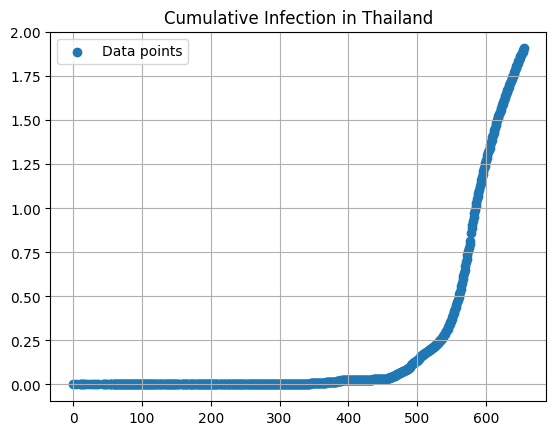

In [309]:
xs = timedelta_infections.index.to_numpy()
ys = np.cumsum(timedelta_infections.to_numpy()) / 1e6

plt.scatter(xs, ys, label="Data points")
plt.title("Cumulative Infection in Thailand")
plt.grid()
plt.legend()
# print(type(ys))

[ 0.01410349 -8.99889339]


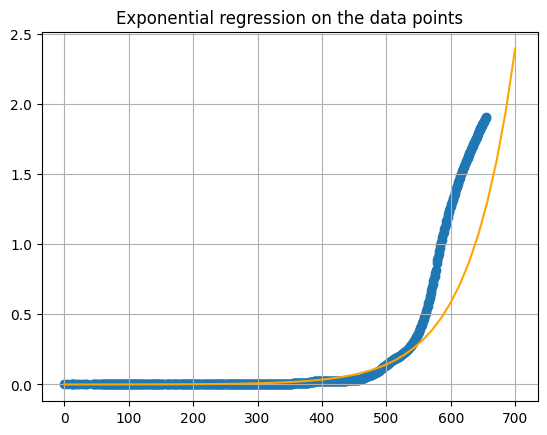

In [310]:
fit = np.polyfit(xs, np.log(ys), 1)
a, b = fit
print(fit)

nxs = np.linspace(0, 700, )
nys = np.exp(a * nxs + b)
plt.scatter(xs, ys)
plt.plot(nxs, nys, color="orange")
plt.title("Exponential regression on the data points")
plt.grid()

In [311]:
# from scipy.optimize import minimize

# def to_min_logf(v):
#     a, b, r = v
#     # b = 600
#     # a = v
#     predicted = a / (1 + b * np.exp(-r * xs))
#     return np.sum((predicted - ys) ** 2)

# # res = minimize(to_min_logf, [2])
# res = minimize(to_min_logf, [3, 395, 7])
# res
# a, b, r = res.x
# def fitted_f(t):
#     return a / (1 + b * np.exp(-r * t))

In [312]:
from sklearn.linear_model import LogisticRegression

log_r = LogisticRegression(n_jobs=-1, max_iter=10000)
log_r.fit(xs.reshape(-1, 1), ys)

ValueError: Unknown label type: 'continuous'

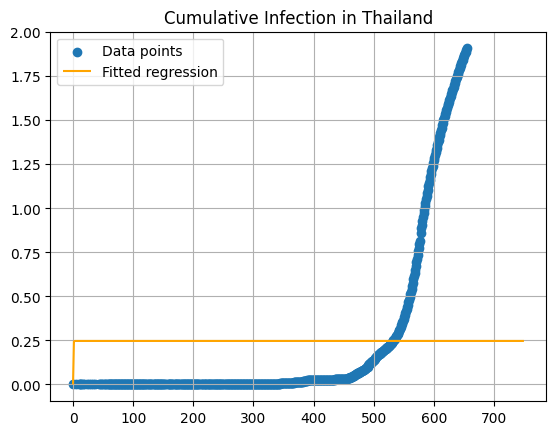

In [ ]:
nxs = np.linspace(0, 750, 500)
# nxs = np.linspace(0, 2000, 1000)
# nys = fitted_f(nxs)
nys = log_r.predict(nxs)

plt.title("Cumulative Infection in Thailand")
plt.scatter(xs, ys, label="Data points")
plt.plot(nxs, nys, label="Fitted regression", color="orange", linestyle=(0, (10, 0)))
plt.legend()
# plt.ylim(0, 1000)
plt.grid()